## Description  
Author: shuheng.mo21@imperial.ac.uk (sm321@ic.ac.uk)          

This notebook contains the parallelisation of solving advection-diffusion  using multigrid method in three-dimensional space implemented with MPI (mpi4py). The script within this notebook is converted to Python scripts and presented at [here](https://github.com/ese-msc-2021/irp-sm321/tree/main/code).          


## Hardware resource details

In [1]:
import os
os.environ['TF_XLA_FLAGS'] = '--tf_xla_enable_xla_devices' ## enable xla devices if available
!lsb_release -a
!nvidia-smi ## check Nvidia GPU details
# !nvidia-smi -L
# !nvidia-smi -q
!lscpu
# !lscpu |grep 'Model name' ## Check CPU details
# !lscpu |grep 'Number of Socket(s):'
# !lscpu | grep 'Core(s) each processor has/per socket:'
# !lscpu | grep 'Number of threads/core:'
!free -h --si | awk  '/Mem:/{print $2}'

# if use tpu
# import tensorflow as tf
# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

No LSB modules are available.
Distributor ID:	Ubuntu
Description:	Ubuntu 18.04.6 LTS
Release:	18.04
Codename:	bionic
Fri Sep  2 08:51:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+------------------

Hardware log for last run of this notebook:

```
Thu Aug 25 19:48:23 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P0    37W / 250W |    423MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
+-----------------------------------------------------------------------------+
Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              4
On-line CPU(s) list: 0-3
Thread(s) per core:  2
Core(s) per socket:  2
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               79
Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz
Stepping:            0
CPU MHz:             2199.998
BogoMIPS:            4399.99
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            56320K
NUMA node0 CPU(s):   0-3
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
26G
```

In [ ]:
! sudo apt install htop # install htop if want to check cpu core usage

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
Suggested packages:
  strace
The following NEW packages will be installed:
  htop
0 upgraded, 1 newly installed, 0 to remove and 20 not upgraded.
Need to get 80.0 kB of archives.
After this operation, 221 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/main amd64 htop amd64 2.1.0-3 [80.0 kB]
Fetched 80.0 kB in 1s (74.6 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Te

## Prerequisites

In [2]:
# ! pip install mpi4py
! python -m pip install mpi4py

# dependencies for GPU accelaration
! pip install line_profiler
# ! pip install -U cupy-cuda111 # still slow on jumping for loops
# ! pip install numba # numba not working well on multi processes
# ! pip install --upgrade taichi  # Install Taichi Lang
# ! pip install pyvista
# config the xvfb server for Ubuntu
# ! sudo apt install libgl1-mesa-glx xvfb

# make folders for output
! mkdir serial_output
! mkdir parallel_output
! mkdir norms
! mkdir result_buildings
! mkdir result_buildings_parallel
! mkdir parallel_steps
! mkdir sub_domains
! mkdir performance_analysis
 
# debug
! mkdir initial_conditions
! mkdir boundary_conditions

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
# import cupy as cp
# import taichi as ti # taichi is able to accelerate any python code (not sure if tensorflow included) if correct decorator specified 
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=18)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)

# import pandas as pd
import math
import time 
# from scipy.stats import multivariate_normal
# from mpl_toolkits.mplot3d import Axes3D

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 5.2 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for mpi4py: filename=mpi4py-3.1.3-cp37-cp37m-linux_x86_64.whl size=2185249 sha256=35875e88e554466fb432c6caa1ceff254cb070f49ac61446707d4bd67e54b6ec
  Stored in directory: /root/.cache/pip/wheels/7a/07/14/6a0c63fa2c6e473c6edc40985b7d89f05c61ff25ee7f0ad9ac
Successfully built mpi4py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67 kB 3.1 MB/s 


## Options for GPU acceleration

In [3]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
is_gpu = len(tf.config.list_physical_devices('GPU')) > 0 
print(is_gpu)

True


## Initial Conditions

(1, 160, 160, 128, 1)

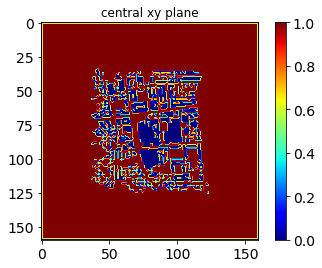

In [ ]:
mesh = np.load('mesh_64_sk.npy')
plt.imshow(mesh[0,:,:,1,0], cmap='jet')
plt.colorbar()
# plt.title('central xy plane',Fontsize=20)
plt.title('central xy plane')
mesh.shape

In [ ]:
input_shape = (1,128,128,128,1)
sigma = np.zeros(input_shape).astype('float32')

for i in range(1,128-1):
    for j in range(1,128-1):
        for k in range(1,128-1):
            if mesh[0][i+16][j+16][k][0] == 0:
                sigma[0][k][j][i][0] = 100000

In [ ]:
# import pyvista as pv
# from pyvista import examples
# mesh = examples.load_hexbeam()
# cpos = [(6.20, 3.00, 7.50),
#         (0.16, 0.13, 2.65),
#         (-0.28, 0.94, -0.21)]

# pv.start_xvfb()
# pl = pv.Plotter()
# pl.add_mesh(mesh, show_edges=True, color='white')
# pl.add_points(mesh.points, color='red',
#               point_size=20)
# pl.camera_position = cpos
# pl.show()

# pyvista not working

(1, 128, 128, 128, 1)

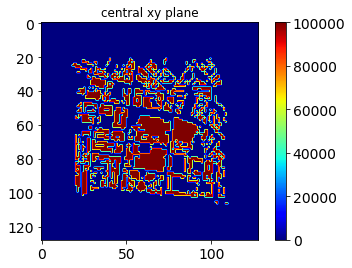

In [ ]:
plt.imshow(sigma[0,1,:,:,0], cmap='jet') # look from xy plane
plt.colorbar()
# plt.title('central xy plane',Fontsize=20)
plt.title('central xy plane')
sigma.shape

(1, 124, 124, 124, 1)

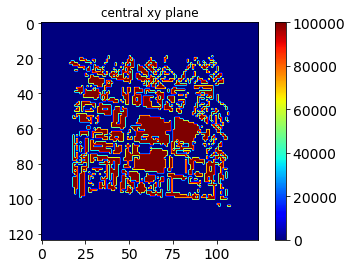

In [ ]:
assert np.allclose(sigma[0,0:1,:,:,0],0) # valid values start from z = 1
assert np.allclose(sigma[0,-3:,:,:,0],0)
assert np.allclose(sigma[0,:,:,0:2,0],0)
assert np.allclose(sigma[0,:,0:2,:,0],0)
assert np.allclose(sigma[0,:,:,0:2,0],0)
assert np.allclose(sigma[0,:,-2:,:,0],0)
assert np.allclose(sigma[0,:,:,-2:,0],0)


# initial condition for parallelisation
parallel_sigma = sigma[0,0:-4, 2:-2, 2:-2, 0].reshape(1,124,124,124,1)

plt.imshow(parallel_sigma[0,1,:,:,0], cmap='jet') # look from xy plane
plt.colorbar()
# plt.title('central xy plane',Fontsize=20)
plt.title('central xy plane')
parallel_sigma.shape

## Fix the cudaCNN runtime issue

In [ ]:
# if reports the "DNN library is not found" error, try update the cudaCNN runtime
# https://www.tensorflow.org/install/source#gpu check the cudaCNN runtime version
! sudo apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2 # tackle the cudaCNN runtime problem of Colab

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be upgraded:
  libcudnn8
1 upgraded, 0 newly installed, 1 to remove and 18 not upgraded.
Need to get 430 MB of archives.
After this operation, 3,139 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (56.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize fro

## Serial implementation

In [5]:
%%writefile naiver_stokes_3D.py

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# import pandas as pd
import math
import time 

# flags and env variables
tf.config.run_functions_eagerly(True) # if we want compile and run as tf.function

# https://cupy.dev/ # accelarate the mult-dim array on GPU
def cupy2tensor(cp_array):
  cap = cp_array.toDlpack()
  return tf.experimental.dlpack.from_dlpack(cap)

def tensor2cupy(tensor):
  cap = tf.experimental.dlpack.to_dlpack(tensor)
  return cp.from_dlpack(cap)

### CFD Parameters
dt = 0.1        # time step (s)
dx = 1          # grid size (m)
Re = 1/4        # diffusion coefficient (m.s-2)
ub = 1          # bulk velocity (m/s)
sigma = 100000  # Absorption coefficent for buildings 
nx = 128        # Grid point in x 
ny = 128        # Grid point in y
nz = 128        # Grid point in z

## Weights of CNNs layers
pd1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pd2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pd3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w1 = np.zeros([1,3,3,3,1])
w1[0,0,:,:,0] = np.array(pd1)*dt*Re/dx**2
w1[0,1,:,:,0] = np.array(pd2)*dt*Re/dx**2 
w1[0,2,:,:,0] = np.array(pd3)*dt*Re/dx**2 

p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]
w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)*dt/dx
w2[0,1,:,:,0] = np.array(p_div_x2)*dt/dx 
w2[0,2,:,:,0] = np.array(p_div_x3)*dt/dx 

w3[0,0,:,:,0] = np.array(p_div_y1)*dt/dx
w3[0,1,:,:,0] = np.array(p_div_y2)*dt/dx
w3[0,2,:,:,0] = np.array(p_div_y3)*dt/dx 

w4[0,0,:,:,0] = np.array(p_div_z1)*dt/dx
w4[0,1,:,:,0] = np.array(p_div_z2)*dt/dx
w4[0,2,:,:,0] = np.array(p_div_z3)*dt/dx

pA1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pA2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pA3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
w5 = np.zeros([1,3,3,3,1])
w5[0,0,:,:,0] = -np.array(pA1)/dx**2
w5[0,1,:,:,0] = -np.array(pA2)/dx**2 
w5[0,2,:,:,0] = -np.array(pA3)/dx**2

pctyu1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
pctyu2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
pctyu3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

pctyv1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
pctyv2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
pctyv3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

pctyw1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
pctyw2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
pctyw3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]

w6 = np.zeros([1,3,3,3,1])
w7 = np.zeros([1,3,3,3,1])
w8 = np.zeros([1,3,3,3,1])
w9 = np.zeros([1,2,2,2,1])
w6[0,0,:,:,0] = np.array(pctyu1)/(dx*dt)
w6[0,1,:,:,0] = np.array(pctyu2)/(dx*dt) 
w6[0,2,:,:,0] = np.array(pctyu3)/(dx*dt) 
w7[0,0,:,:,0] = np.array(pctyv1)/(dx*dt) 
w7[0,1,:,:,0] = np.array(pctyv2)/(dx*dt) 
w7[0,2,:,:,0] = np.array(pctyv3)/(dx*dt) 
w8[0,0,:,:,0] = np.array(pctyw1)/(dx*dt) 
w8[0,1,:,:,0] = np.array(pctyw2)/(dx*dt) 
w8[0,2,:,:,0] = np.array(pctyw3)/(dx*dt)
w9[0,:,:,:,0] = 0.125

kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

### Libraries for solving momentum equation
CNN3D_central_2nd_dif = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_zadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer),
])

CNN3D_Sw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_8,
                                bias_initializer=bias_initializer),
])


CNN3D_pu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_pv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_pw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

### Libraries for solving the Poisson equation
CNN3D_A_512 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_256 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(256, 256, 256, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

### Libraries for solving multi-grid
CNN3D_res_512 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_256 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(256, 256, 256, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_prol_256 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(256, 256, 256, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),  
])

CNN3D_prol_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)), 
])

CNN3D_prol_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),  
])

CNN3D_prol_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)), 
])

CNN3D_prol_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

### Functions linking to the AI libraries

##@profile
def boundary_condition_velocity(values_u,values_v,values_w,nx):
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w) 

    tempu[0,:,:,0,0].assign(tf.Variable(tf.ones((1,nx,nx)))[0,:]*ub) 
    tempv[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])    
    tempw[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])    

    tempu[0,:,:,nx-1,0].assign(tf.Variable(tf.ones((1,nx,nx)))[0,:]*ub) 
    tempv[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])   
    tempw[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    
    tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,1,:,0])     
    tempv[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    tempw[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
        
    tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-2,:,0])      
    tempv[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempw[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    
    tempu[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
    tempv[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    tempw[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
        
    tempu[0,nx-1,:,:,0].assign(tf.Variable(values_u)[0,nx-2,:,:,0])      
    tempv[0,nx-1,:,:,0].assign(tf.Variable(values_v)[0,nx-2,:,:,0])     
    tempw[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])      
    return tempu,tempv,tempw

##@profile
def boundary_condition_pressure(values_p,nx):    
    tempp = tf.Variable(values_p)   
    tempp[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,1,0])
    
    tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,1,:,0])     
    tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-2,:,0]) 
    
    tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,1,:,:,0])     
    tempp[0,nx-1,:,:,0].assign(tf.Variable(values_p)[0,nx-2,:,:,0])  
    return tempp

##@profile
def boundary_condition_source(b,nx):    
    tempb = tf.Variable(b)   
    tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,1,0])

    #return tf.convert_to_tensor(b.reshape(1,nx, ny, nz, 1)) # return as tensor
    return tempb

##@profile
def bluff_body(values_u,values_v,values_w,sigma):
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma) 
    temp3 = values_w / (1+dt*sigma)     

    return temp1,temp2,temp3

# we do not need optimisation for save method
def save_data(values_u,values_v,values_w,values_p,n_out,itime):
    if itime % n_out == 0:  
        np.save("result_buildings/result_SK_city_Re200/u"+str(itime), arr=values_u[0,:,:,:,0])
        np.save("result_buildings/result_SK_city_Re200/v"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("result_buildings/result_SK_city_Re200/w"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("result_buildings/result_SK_city_Re200/p"+str(itime), arr=values_p[0,:,:,:,0])

##############################################################################################################################################

### timer
multi_grid_counter = 0

### Initialisation of the CFD model
input_shape = (1,nx,ny,nz,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)
sigma = np.zeros(input_shape).astype('float32')

# ------------------ Numerical set up ----------------------
multi_itr = 10        # Iterations of multi-grid 
j_itr = 1             # Iterations of Jacobi 
ntime = 100           # Time steps
n_out = 500           # Results output
nrestart = 0          # Last time step for restart
ctime_old = 0         # Last computational time for restart
mgsolver = True       # Multigrid
save_fig = False      # Saving results 
Restart = False       # Restart
ctime = 0             # Initialise computational time 
# ----------------------------------------------------------

# ------------------ Load geometry meshing -----------------
mesh = np.load('mesh_64_sk.npy')
# ----------------------------------------------------------

# --------------- Reading previous results -----------------
if Restart == True:
    temp1 = np.load('result_buildings/result_SK_city_Re200/u8000.npy').astype('float32')
    temp2 = np.load('result_buildings/result_SK_city_Re200/v8000.npy').astype('float32')
    temp3 = np.load('result_buildings/result_SK_city_Re200/w8000.npy').astype('float32')
    temp4 = np.load('result_buildings/result_SK_city_Re200/p8000.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 8000
    ctime_old = nrestart*dt
# ----------------------------------------------------------    

print('--------------- General numerical parameters ----------------')
print('Computational domain resolution:', values_u.shape)
print('Mesh resolution:', mesh.shape)
print('Time step:', ntime)
print('Initial time:', ctime)
print('-------------------------------------------------------------')

### build the model based on the numpy data file
for i in range(1,nx-1):
    for j in range(1,ny-1):
        for k in range(1,nz-1):
            if mesh[0][i+16][j+16][k][0] == 0:
                sigma[0][k][j][i][0] = 100000

sigma = tf.convert_to_tensor(sigma)
# np.save("/content/initial_conditions/serial_IC",sigma)

### solve the problem with Multigrid method
start = time.perf_counter()
for itime in range(ntime): 
    ctime = ctime + dt + ctime_old
# ------------------ Boundary conditions ----------------------    
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,nx)
    values_p = boundary_condition_pressure(values_p,nx)
# ------------------------------------------------------------- 

# ------------------ Momentum equations -----------------------  
    a_u = CNN3D_central_2nd_dif(values_u) - \
    values_u*CNN3D_central_2nd_xadv(values_u) - \
    values_v*CNN3D_central_2nd_yadv(values_u) - \
    values_w*CNN3D_central_2nd_zadv(values_u)
    b_u = 0.5*a_u + values_u

    a_v = CNN3D_central_2nd_dif(values_v) - \
    values_u*CNN3D_central_2nd_xadv(values_v) - \
    values_v*CNN3D_central_2nd_yadv(values_v) - \
    values_w*CNN3D_central_2nd_zadv(values_v)
    b_v = 0.5*a_v + values_v

    a_w = CNN3D_central_2nd_dif(values_w) - \
    values_u*CNN3D_central_2nd_xadv(values_w) - \
    values_v*CNN3D_central_2nd_yadv(values_w) - \
    values_w*CNN3D_central_2nd_zadv(values_w)
    b_w = 0.5*a_w + values_w

    #print("Range bu: ", np.min(b_u),np.max(b_u))
    #print("Range bv: ", np.min(b_v),np.max(b_v))
    #print("Range bw: ", np.min(b_w),np.max(b_w))

    [b_u,b_v,b_w] = boundary_condition_velocity(b_u,b_v,b_w,nx) # compute boundary velocity

    c_u = CNN3D_central_2nd_dif(b_u) - \
    b_u*CNN3D_central_2nd_xadv(b_u) - \
    b_v*CNN3D_central_2nd_yadv(b_u) - \
    b_w*CNN3D_central_2nd_zadv(b_u)
    
    c_v = CNN3D_central_2nd_dif(b_v) - \
    b_u*CNN3D_central_2nd_xadv(b_v) - \
    b_v*CNN3D_central_2nd_yadv(b_v) - \
    b_w*CNN3D_central_2nd_zadv(b_v)

    c_w = CNN3D_central_2nd_dif(b_w) - \
    b_u*CNN3D_central_2nd_xadv(b_w) - \
    b_v*CNN3D_central_2nd_yadv(b_w) - \
    b_w*CNN3D_central_2nd_zadv(b_w)
    
    values_u = values_u + c_u    
    values_v = values_v + c_v
    values_w = values_w + c_w
# ------------------------------------------------------------- 

# ------------------ Immersed Boundary method -----------------  
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# -------------------------------------------------------------

# ------------------ Pressure gradient ------------------------            
    values_u = values_u - CNN3D_pu(values_p)
    values_v = values_v - CNN3D_pv(values_p)  
    values_w = values_w - CNN3D_pw(values_p)     
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,nx)
# -------------------------------------------------------------
    
# ------------------ Possion equation -------------------------    

    # possion equation (multi-grid) A*P = Su
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v) + CNN3D_Sw(values_w))
    b = boundary_condition_source(b,nx)

    # multi-grid method
    multi_grid_start = time.perf_counter()
    if mgsolver == True:
        for multi_grid in range(multi_itr):
            w_2 = tf.zeros([1,2,2,2,1])
            r = CNN3D_A_128(values_p) - b   
            r = tf.Variable(r)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
            
            # restriction
            r_64 = CNN3D_res_128(r) 
            r_32 = CNN3D_res_64(r_64) 
            r_16 = CNN3D_res_32(r_32) 
            r_8 = CNN3D_res_16(r_16) 
            r_4 = CNN3D_res_8(r_8) 
            r_2 = CNN3D_res_4(r_4) 
            # r1 = CNN3D_res_2(r_2)  
            
            # prolongation
            # for Jacobi in range(j_itr):
            #     w = (w - CNN3D_A_1(w)/w5[0,1,1,1,0] + r1/w5[0,1,1,1,0])
            # w_2 = CNN3D_prol_1(w)

            for Jacobi in range(j_itr):
                w_2 = (w_2 - CNN3D_A_2(w_2)/w5[0,1,1,1,0] + r_2/w5[0,1,1,1,0])

            w_4 = CNN3D_prol_2(w_2) 
            for Jacobi in range(j_itr):
                w_4 = (w_4 - CNN3D_A_4(w_4)/w5[0,1,1,1,0] + r_4/w5[0,1,1,1,0])

            w_8 = CNN3D_prol_4(w_4) 
            for Jacobi in range(j_itr):
                w_8 = (w_8 - CNN3D_A_8(w_8)/w5[0,1,1,1,0] + r_8/w5[0,1,1,1,0])

            w_16 = CNN3D_prol_8(w_8) 
            for Jacobi in range(j_itr):
                w_16 = (w_16 - CNN3D_A_16(w_16)/w5[0,1,1,1,0] + r_16/w5[0,1,1,1,0])

            w_32 = CNN3D_prol_16(w_16) 
            for Jacobi in range(j_itr):
                w_32 = (w_32 - CNN3D_A_32(w_32)/w5[0,1,1,1,0] + r_32/w5[0,1,1,1,0])

            w_64 = CNN3D_prol_32(w_32) 
            for Jacobi in range(j_itr):
                w_64 = (w_64 - CNN3D_A_64(w_64)/w5[0,1,1,1,0] + r_64/w5[0,1,1,1,0])

            w_128 = CNN3D_prol_64(w_64) 

            # correction
            values_p = values_p - w_128
            values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])         
            values_p = (values_p - CNN3D_A_128(values_p)/w5[0,1,1,1,0] + b/w5[0,1,1,1,0])          
# -------------------------------------------------------------
    multi_grid_end = time.perf_counter()
    multi_grid_counter += (multi_grid_end - multi_grid_start)

# ------------------ Pressure gradient ------------------------  
    values_p = boundary_condition_pressure(values_p,nx)
    values_u = values_u - CNN3D_pu(values_p) # pressure along x direct
    values_v = values_v - CNN3D_pv(values_p) # pressure along y direct
    values_w = values_w - CNN3D_pw(values_p) # pressure along z direct      
# -------------------------------------------------------------

# ------------------ Immersed Boundary method -----------------  
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,nx)    
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,sigma)
# -------------------------------------------------------------
    if itime == ntime-1:
        print('ctime',ctime)
    if save_fig == True:
        save_data(values_u,values_v,values_w,values_p,n_out,itime+nrestart)

    print("[TIME STEP {}] ".format(itime))

# END OF TIMESTEP HERE
end = time.perf_counter()
total_time = end - start
print('Total timestepping runtime',total_time)
print('Total multigrid runtime',multi_grid_counter)
print('Runtime mulitigrid/total(%): ',(multi_grid_counter/total_time)*100)

# save the result
np.save('serial_output/serial_values_p.npy',values_p)
np.save('serial_output/serial_values_u.npy',values_u)
np.save('serial_output/serial_values_v.npy',values_v)
np.save('serial_output/serial_values_w.npy',values_w)

Writing naiver_stokes_3D.py


## Profiling the serial implementation

### Profiling thread time

In [ ]:
## profiling and performance analysis
! python -m cProfile -o performance_analysis/serial_performance.prof naiver_stokes_3D.py

2022-09-02 01:07:10.484088: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
--------------- General numerical parameters ----------------
Computational domain resolution: (1, 128, 128, 128, 1)
Mesh resolution: (1, 160, 160, 128, 1)
Time step: 100
Initial time: 0
-------------------------------------------------------------
[TIME STEP 0] 
[TIME STEP 1] 
[TIME STEP 2] 
[TIME STEP 3] 
[TIME STEP 4] 
[TIME STEP 5] 
[TIME STEP 6] 
[TIME STEP 7] 
[TIME STEP 8] 
[TIME STEP 9] 
[TIME STEP 10] 
[TIME STEP 11] 
[TIME STEP 12] 
[TIME STEP 13] 
[TIME STEP 14] 
[TIME STEP 15] 
[TIME STEP 16] 
[TIME STEP 17] 
[TIME STEP 18] 
[TIME STEP 19] 
[TIME STEP 20] 
[TIME STEP 21] 
[TIME STEP 22] 
[TIME STEP 23] 
[TIME STEP 24] 
[TIME STEP 25] 
[TIME STEP 26] 
[TIME STEP 27] 
[TIME STEP 28] 
[TIME STEP 29] 
[TIME STEP 30] 
[TIME STEP 31] 
[TIME STEP 32] 
[TIME STEP 33] 

In [ ]:
# add @profile decorator before the functions you want to profile
! python -m pstats performance_analysis/serial_performance.prof

Welcome to the profile statistics browser.
performance_analysis/serial_performance.prof% sort tottime
performance_analysis/serial_performance.prof% stats 10
Fri Sep  2 01:08:17 2022    performance_analysis/serial_performance.prof

         36138753 function calls (33894966 primitive calls) in 71.709 seconds

   Ordered by: internal time
   List reduced from 13120 to 10 due to restriction <10>

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   221938   18.418    0.000   18.537    0.000 {built-in method tensorflow.python._pywrap_tfe.TFE_Py_FastPathExecute}
        1    5.721    5.721   71.743   71.743 naiver_stokes_3D.py:3(<module>)
    96310    3.013    0.000    4.027    0.000 /usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/constant_op.py:74(convert_to_eager_tensor)
1103480/179502    2.489    0.000   33.914    0.000 /usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1068(op_dispatch_handler)
  2615239    2.182    0.000  

### Profiling functions

In [ ]:
## we can also do a more detailed analysis on each member function
! kernprof -l naiver_stokes_3D.py

Exception ignored in: <function _get_module_lock.<locals>.cb at 0x7f883227a050>
Traceback (most recent call last):
  File "<frozen importlib._bootstrap>", line 178, in cb
KeyboardInterrupt: 
Wrote profile results to naiver_stokes_3D.py.lprof


In [ ]:
! python -m line_profiler naiver_stokes_3D.py.lprof

Timer unit: 1e-06 s



By looking at the result we can see the function `naiver_stokes_3D.py:450(boundary_condition_source)` is the most possible obstacle for the overall performance.

Possible optimization solution:
1. Using `tf.function` to optimise functions ==> slightly improved the performance. [x]
2. 

## MPI Subroutines

In [6]:
%%writefile halo_exchange.py

# imports
import os
import sys
import numpy as np  # cupy can be used as optimisation if CUDA/AMD GPUs are available
from tensorflow import keras
import tensorflow as tf
import math
from mpi4py import MPI

assert tf.__version__ >= "2.0"
np.set_printoptions(threshold=sys.maxsize) # print out the full numpy array

############################## Global variables ################################
comm = None               # MPI communicator
rank = 0                  # Process rank    
num_process = 1           # Number of processors
rows,cols = 1,1           # Cartesian topology for 2D structured mesh
sub_nx, sub_ny, sub_nz = 0,0,0 # Dimensions for sub-domain up to 3D
neighbors = [-2, -2, -2, -2, -2, -2] # Process rank for all neighboring subdomains
current_vector = None     # 1D Block structured sub-domain
current_domain = None     # 2D Block Structured sub-domain
current_cube = None       # 3D Block Structured sub-domain
is_double_precision = False   # variable control the precision of MPI communication buffer vlaues
is_diagonal_exchange = False  # control do we need exchange values on corners

# TODO: the best practice is to use OOP
# class halo_exchange:
#   # initialization
#   def __init__(self) -> None:

#   # member functions
  
############################## Util functions ##################################
# clear the cached subdomain to release memory
def clear_cache():
  global current_domain, current_cube
  if current_domain != None:
    del current_domain
  if current_cube != None:
    del current_cube

def id_2_idx(rank, cols):
    """
    return the indices of processor in processor
    grid space based on the processor ranks

    Parameters
    ----------
    rank : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    return rank/cols, rank % cols

def idx_2_id(rows, cols, id_row, id_col):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    if id_row >= rows or id_row < 0:
        return -1
    if id_col >= cols or id_col < 0:
        return -1
    return id_row * id_col + id_col

def generate_dimension_2D(num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    global rows,cols
    rows,cols = 0,0
    min_gap = num_process
    max_val = int(num_process**0.5 + 1)
    for i in range(1, max_val+1):
        if num_process % i == 0:
            gap = abs(num_process/i - i)
            if gap < min_gap:
                min_gap = gap
                rows = i
                cols = int(num_process / i)

    return rows, cols

def generate_dimension_3D(num_process):
  # TODO: generate dimension for 3D processor grid space
  pass

def domain_decomposition_strip(mesh, num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    sub_domains = np.hsplit(mesh, num_process)
    return sub_domains

def domain_decomposition_grid(mesh, rows, cols):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    nx, ny = mesh.shape
    assert nx % rows == 0, f"{nx} rows is not evenly divisible by {rows}"
    assert ny % cols == 0, f"{ny} cols is not evenly divisible by {cols}"
    sub_nx = nx//rows
    sub_ny = ny//cols
    return (mesh.reshape(nx//sub_nx, sub_nx, -1, sub_ny)
            .swapaxes(1, 2)
            .reshape(-1, sub_nx, sub_ny))
    
def domain_decomposition_cube(mesh, proc_grid_dim):
  """
  return the rank of processor in processor
  grid space based on the indices

  Parameters
  ----------
  rows : int
      the rank of the process
  cols :
      the colun number of the process grid space

  Returns
  -------
  int
      x and y coordinate of the processor

  Raises
  ------
  None
  """
  global sub_nx,sub_ny,sub_nz
  nx, ny, nz = mesh.shape
  
  assert nx % proc_grid_dim[0] == 0, f"{nx} grids along x axis is not evenly divisible by {proc_grid_dim[0]}"
  assert ny % proc_grid_dim[1] == 0, f"{ny} grids along y axis is not evenly divisible by {proc_grid_dim[1]}"
  assert nz % proc_grid_dim[2] == 0, f"{nz} grids along z axis is not evenly divisible by {proc_grid_dim[2]}"
  
  sub_nx = nx // proc_grid_dim[0]
  sub_ny = ny // proc_grid_dim[1]
  sub_nz = nz // proc_grid_dim[2]

  new_shape = (sub_nx,sub_ny,sub_nz)
  num_cubes = np.array(mesh.shape) // new_shape
  split_shape = np.column_stack([num_cubes, new_shape]).reshape(-1)
  order = np.array([0,2,4,1,3,5])

  return mesh.reshape(split_shape).transpose(order).reshape(-1, *new_shape) # return a numpy array


def find_neighbours_id_2D(rank, rows, cols, proc_row_idx, proc_col_idx,num_process):
    """
    return the rank of processor in processor
    grid space based on the indices

    Parameters
    ----------
    rows : int
        the rank of the process
    cols :
        the colun number of the process grid space

    Returns
    -------
    int
        x and y coordinate of the processor

    Raises
    ------
    None
    """
    # TODO: Consider the conditions in periodic boundaries (if required) 
    # left,right,top,bottom = find_neighbours_id(rank,rows,cols,proc_row_idx,proc_col_idx,num_process)
    # print("[INFO] Neighbors of process {}: left={},right={},up={},down={}".format(rank,left,right,top,bottom))
    left_neighbour = (rank - 1) if proc_col_idx != 0 and rank >=1 else MPI.PROC_NULL
    right_neighbour = (rank + 1) if proc_col_idx != (cols-1) and rank < num_process - 1 else MPI.PROC_NULL
    top_neighbour = (rank - cols) if proc_row_idx != 0 and (rank - cols) >=0 else MPI.PROC_NULL
    bottom_neighbour = (rank + cols) if proc_row_idx != (rows-1) and (rank + cols) <= num_process-1 else MPI.PROC_NULL

    return left_neighbour, right_neighbour, top_neighbour, bottom_neighbour

# padding halos to sub-domain manually
def padding_block_halo_1D(sub_domain,halo_size,halo_val = 0):
  if tf.is_tensor(sub_domain):
     sub_domain = sub_domain.numpy()

  if sub_domain.ndim > 1:
    sub_domain = np.squeeze(sub_domain,axis=0)
    sub_domain = np.squeeze(sub_domain,axis=-1)

  return np.pad(sub_domain,(halo_size,halo_size),'constant',constant_values=(halo_val,))

def padding_block_halo_2D(sub_domain,halo_size,halo_val = 0):
  if tf.is_tensor(sub_domain):
     sub_domain = sub_domain.numpy()

  if sub_domain.ndim > 2:
    sub_domain = np.squeeze(sub_domain)

  # note padding halo values with 0 by default
  return np.pad(sub_domain,(halo_size,halo_size),'constant',constant_values=(halo_val,))

# incase we need diff size of halos on each boudary
def padding_block_halo_2D_custom(sub_domain,halo_dim,halo_vals):
  pass 

def padding_block_halo_3D(sub_cube,halo_size,halo_val = 0):
  if tf.is_tensor(sub_cube):
    sub_cube = sub_cube.numpy()

  if sub_cube.ndim > 3:
    sub_cube = remove_one_dims(sub_cube)
  
  nx,ny,nz = sub_cube.shape

  # note padding halo values with 0 by default
  ans = np.pad(sub_cube,(halo_size,halo_size),'constant',constant_values=(halo_val,))
  return tf.convert_to_tensor(ans.reshape(1,nx+2,ny+2,nz+2,1))

# incase we need diff size of halos on each boudary
def padding_block_halo_3D_custom(sub_cube,halo_dim,halo_vals):
  pass 


# remove trivial 1 dimensions of the tensor.numpy()
def remove_one_dims(input):
  while input.ndim > 3:
      if input.shape[0] == 1:
          input = np.squeeze(input,axis = 0)
      if input.shape[-1] == 1:
          input = np.squeeze(input,axis = -1)
  return  input

############################## MPI Initialization ##############################
def mpi_initialization(proc_grid_dim,is_periodic,is_reordered):
  global rank,num_process,comm

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  assert num_process > 1, f"Parallelisation involves 2 or more processes, otherwise run implementation without MPI"

  # create Cartesian Topology
  comm = MPI.COMM_WORLD.Create_cart(
    proc_grid_dim,
    periods=is_periodic, # set True if periodic boundary
    reorder=is_reordered)
  
  # get the rank of current process
  rank = comm.rank

def domain_decomposition_1D(values, nx, is_periodic=False,is_reordered=True):
  global num_process,comm,rank, sub_nx, neighbors, current_vector
  LEFT = 0
  RIGHT = 1

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  proc_grid_dim = (num_process,)
  mpi_initialization(proc_grid_dim, is_periodic, is_reordered)

  neighbors[LEFT], neighbors[RIGHT] = comm.Shift(0, 1)

  # print("NEIGHBORS OF {} ".format(rank),neighbors)

  sub_domains = domain_decomposition_strip(values.reshape(nx,), num_process)  # (1,x)
  sub_nx = sub_domains[rank].shape[0]
  current_vector = np.pad(sub_domains[rank],(1,1),"constant",constant_values=(0,))

  return sub_nx, current_vector

# grid decomposition for 2D block structured meshes
def domain_decomposition_2D(values, nx, ny, is_periodic=(False,False),is_reordered=True):
  global comm,rank, sub_nx, sub_ny, neighbors,current_domain

  TOP = 0
  BOTTOM = 1
  LEFT = 2
  RIGHT = 3

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  proc_grid_dim = generate_dimension_2D(num_process)
  mpi_initialization(proc_grid_dim, is_periodic, is_reordered)

  if rows == 1 or cols == 1:
    sub_domains = domain_decomposition_strip(values.reshape(nx,ny), num_process)  # 2 process
    sub_nx, sub_ny = sub_domains[0].shape
  else:
    # if the process arrays is 2D then use grid decomposition to split domain
    sub_domains = domain_decomposition_grid(values.reshape(nx,ny), rows, cols)
    sub_nx, sub_ny = sub_domains[0].shape

  # create customized MPI datatype
  grid_size = [sub_nx,sub_ny]
  subdomain_size = [sub_nx+2, sub_ny + 2]
  start_indices = [1,1]

  # customised data type for 2D problem
  # comm_datatype = MPI.DOUBLE.Create_subarray(subdomain_size, grid_size, start_indices).Commit()

  # find the processor id of all neighboring processors
  neighbors[TOP], neighbors[BOTTOM] = comm.Shift(0, 1)
  neighbors[LEFT],  neighbors[RIGHT]  = comm.Shift(1, 1)

  current_domain = np.pad(sub_domains[rank],(1,1),"constant",constant_values=(0,))

  return sub_nx, sub_ny, current_domain

# grid decomposition for 3D block structured meshes
def domain_decomposition_3D(values, nx, ny, nz, is_periodic=(False,False,False),is_reordered=True):
  global rank, num_process, neighbors, current_cube

  # neighbor indices
  LEFT = 0
  RIGHT = 1
  FRONT = 2
  BEHIND = 3
  TOP = 4
  BOTTOM = 5

  num_process = MPI.COMM_WORLD.Get_size() # get number of process
  # TODO: create Cartesian topology for processes in 3D space
  proc_grid_dim = (2,2,2) # divide to 2x2x2, 8 subcubes
  #proc_grid_dim = (4,4,4) # divide to 4x4x4, 64 subcubes
  mpi_initialization(proc_grid_dim, is_periodic, is_reordered)
  
  # edge case, if 1 process we do nothing
  if num_process == 1:
    return nx,ny,nz,values

  if tf.is_tensor(values):
    sub_cubes = domain_decomposition_cube(tf.reshape(values,[nx,ny,nz]).numpy(),proc_grid_dim)
    # we can do this in complete tensorflow routines
    # current_cube = tf.convert_to_tensor(sub_cubes[rank], dtype=tf.float32)
    # paddings = tf.constant([[1, 1], [1, 1], [1, 1]])
    # current_cube = tf.pad(current_cube, paddings)
  else:
    sub_cubes = domain_decomposition_cube(values.reshape(nx,ny,nz),proc_grid_dim) # if it is numpy reshape directly

  # create customized MPI datatype
  cube_size = [sub_nx,sub_ny,sub_nz]
  subcube_size = [sub_nx+2, sub_ny + 2, sub_nz + 2]
  start_indices = [1,1,1]

  # use datatypes with 64 bits
  # comm_datatype_3D = MPI.DOUBLE.Create_subarray(subcube_size, cube_size, start_indices).Commit()

  # padding the halo grids
  current_cube = np.pad(sub_cubes[rank],(1,1),'constant',constant_values=(0,))

  # print("[CURRENT_CUBE_SHAPE of {}]".format(rank), current_cube.shape)


  # find neighbors (note here 0,1,2 are x,y,z coordinates respectively)
  neighbors[LEFT], neighbors[RIGHT] = comm.Shift(2, 1)
  neighbors[FRONT],  neighbors[BEHIND]  = comm.Shift(1, 1)
  neighbors[BOTTOM],  neighbors[TOP]  = comm.Shift(0, 1)

  # print("[NEIGHBORS of {}] ".format(rank),neighbors)

  # return tf.convert_to_tensor(current_cube,np.float64)
  return sub_nx, sub_ny, sub_nz, current_cube

def structured_halo_update_1D(input_vector):
  global comm,neighbors,current_vector,sub_nx

  if tf.is_tensor(input_vector):
     current_vector = input_vector.numpy()
  else:
    current_vector = input_vector

  if current_vector.ndim > 1:
    current_vector = np.squeeze(current_vector,axis=0)
    current_vector = np.squeeze(current_vector,axis=-1)

  #print("reduced shape: ",current_vector.shape)  

  LEFT = 0
  RIGHT = 1

  sub_nx = current_vector.shape[0]

  send_left = np.copy(np.ascontiguousarray(current_vector[1]))
  recv_right = np.empty_like(send_left)
  send_right = np.copy(np.ascontiguousarray(current_vector[-2]))
  recv_left = np.empty_like(send_right)

  # Blocking
  # comm.Send(buf=[send_left,1,MPI.DOUBLE],dest=neighbors[LEFT],tag=11) # send to left
  # comm.Send(buf=[send_right,1,MPI.DOUBLE],dest=neighbors[RIGHT],tag=22) # send to left
  # comm.Recv(buf=[recv_right,1,MPI.DOUBLE],source=neighbors[RIGHT],tag=11)
  # comm.Recv(buf=[recv_left,1,MPI.DOUBLE],source=neighbors[LEFT],tag=22)

  # Non-blocking send-recv, which gives the same result
  requests = []
  requests.append(comm.Isend([send_left,1,MPI.DOUBLE],dest=neighbors[LEFT]))
  requests.append(comm.Isend([send_right,1,MPI.DOUBLE],dest=neighbors[RIGHT]))
  requests.append(comm.Irecv([recv_right,1,MPI.DOUBLE],source=neighbors[RIGHT]))
  requests.append(comm.Irecv([recv_left,1,MPI.DOUBLE],source=neighbors[LEFT]))
  MPI.Request.Waitall(requests)
  requests.clear()

  if neighbors[RIGHT] != -2:
    current_vector[-1] = recv_right
  if neighbors[LEFT] != -2:
    current_vector[0] = recv_left

  return tf.convert_to_tensor(current_vector.reshape(1,sub_nx,1))

# parallel halo update for 2D block structured mesh
def structured_halo_update_2D(input_domain):
  global comm,neighbors,current_domain,sub_nx,sub_ny

  current_domain = input_domain

  if tf.is_tensor(input_domain):
     current_domain = input_domain.numpy()

  if current_domain.ndim > 2:
    current_domain = remove_one_dims(current_domain)

  sub_nx, sub_ny = current_domain.shape

  # neighbor indices
  TOP = 0
  BOTTOM = 1
  LEFT = 2
  RIGHT = 3
  
  # left and right
  # try non-blocking send and blocking receive
  send_left = np.copy(np.ascontiguousarray(current_domain[1:-1,1]))
  recv_right = np.zeros_like(send_left)
  send_right = np.copy(np.ascontiguousarray(current_domain[1:-1,-2]))
  recv_left = np.zeros_like(send_right)

  # Non-blocking send
  comm.Send(buf=[send_left,MPI.DOUBLE],dest=neighbors[LEFT],tag=11) # send to left
  comm.Send(buf=[send_right,MPI.DOUBLE],dest=neighbors[RIGHT],tag=22) # send to left
  comm.Recv(buf=[recv_right,MPI.DOUBLE],source=neighbors[RIGHT],tag=11)
  comm.Recv(buf=[recv_left,MPI.DOUBLE],source=neighbors[LEFT],tag=22)
  if neighbors[RIGHT] != -2:
    current_domain[1:-1,-1] = recv_right
  if neighbors[LEFT] != -2:
    current_domain[1:-1,0] = recv_left

  send_top = np.copy(np.ascontiguousarray(current_domain[1,:]))
  recv_bottom = np.zeros_like(send_top)
  send_bottom = np.copy(np.ascontiguousarray(current_domain[-2,:]))
  recv_top = np.zeros_like(send_bottom)

  comm.Send(buf=[send_top,MPI.DOUBLE],dest=neighbors[TOP],tag=33) # send to left
  comm.Send(buf=[send_bottom,MPI.DOUBLE],dest=neighbors[BOTTOM],tag=44) # send to left
  comm.Recv(buf=[recv_bottom,MPI.DOUBLE],source=neighbors[BOTTOM],tag=33)
  comm.Recv(buf=[recv_top,MPI.DOUBLE],source=neighbors[TOP],tag=44)
  if neighbors[TOP] != -2:
    current_domain[0,:] = recv_top
  if neighbors[BOTTOM] != -2:
    current_domain[-1,:] = recv_bottom

  # return current_domain
  return tf.convert_to_tensor(current_domain.reshape(1,sub_nx, sub_ny,1))

# non-blocking send and recv
def structured_halo_update_3D(input_cube):
  global current_cube, neighbors,sub_nx, sub_ny,sub_nz

  current_cube = input_cube

  if tf.is_tensor(input_cube):
     current_cube = current_cube.numpy()

  if input_cube.ndim > 3:
    current_cube = remove_one_dims(current_cube)

  sub_nx,sub_ny,sub_nz = current_cube.shape

  # neighbor indices
  LEFT = 0
  RIGHT = 1
  FRONT = 2
  BEHIND = 3
  TOP = 4
  BOTTOM = 5

  requests = [] # [ None ] * (2*nprocs) for other languages

  # FRONT AND BEHIND
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[1:-1,1,1:-1]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1:-1,-2,1:-1]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[FRONT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[FRONT]))
  MPI.Request.Waitall(requests)
  requests.clear()

  # update front and behind
  if neighbors[FRONT] != -2:
    current_cube[1:-1,0,1:-1] = recvbuffer_2
  if neighbors[BEHIND] != -2:
    current_cube[1:-1,-1,1:-1] = recvbuffer_1

  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[:,:,1]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[:,:,-2]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests = [] # [ None ] * (2*nprocs) for other languages
  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[LEFT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[LEFT]))
  MPI.Request.Waitall(requests)
  requests.clear()

  if neighbors[LEFT] != -2:
    current_cube[:,:,0] = recvbuffer_2
  if neighbors[RIGHT] != -2:
    current_cube[:,:,-1] = recvbuffer_1

  requests = [] # [ None ] * (2*nprocs) for other languages
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[-2,:,:]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1,:,:]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[TOP]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[TOP]))
  MPI.Request.Waitall(requests)
  requests.clear()

  if neighbors[TOP] != -2:
    current_cube[-1,:,:] = recvbuffer_2
  if neighbors[BOTTOM] != -2:
    current_cube[0,:,:] = recvbuffer_1

  return tf.convert_to_tensor(current_cube.reshape(1,sub_nx,sub_ny,sub_nz,1))

def halo_update_1_cube(input_cube):
  global current_cube, neighbors,sub_nx, sub_ny,sub_nz

  sub_nx, sub_ny, sub_nz = input_cube.shape
  
  # input cube is a 3D numpy array
  current_cube = tf.reshape(input_cube,[sub_nx, sub_ny, sub_nz]).numpy()

  # neighbor indices
  LEFT = 0
  RIGHT = 1
  FRONT = 2
  BEHIND = 3
  TOP = 4
  BOTTOM = 5

  requests = []

  # FRONT AND BEHIND
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[1:-1,0,1:-1]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[1:-1,-1,1:-1]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[FRONT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BEHIND]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[FRONT]))
  MPI.Request.Waitall(requests)

  if neighbors[FRONT] != -2:
    current_cube[1:-1,0,1:-1] = recvbuffer_2
  if neighbors[BEHIND] != -2:
    current_cube[1:-1,-1,1:-1] = recvbuffer_1

  # LEFT AND RIGHT
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[:,:,0]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[:,:,-1]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.clear() 
  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[LEFT]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[RIGHT]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[LEFT]))
  MPI.Request.Waitall(requests)

  # Update the left and right
  if neighbors[LEFT] != -2:
    current_cube[:,:,0] = recvbuffer_2
  if neighbors[RIGHT] != -2:
    current_cube[:,:,-1] = recvbuffer_1

  #TOP AND BOTTOM
  sendbuffer_1 = np.copy(np.ascontiguousarray(current_cube[-1,:,:]))
  sendbuffer_2 = np.copy(np.ascontiguousarray(current_cube[0,:,:]))
  recvbuffer_1 = np.empty_like(sendbuffer_2)
  recvbuffer_2 = np.empty_like(sendbuffer_1)

  requests.clear()
  requests.append(comm.Isend(sendbuffer_1,dest=neighbors[TOP]))
  requests.append(comm.Isend(sendbuffer_2,dest=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_1,source=neighbors[BOTTOM]))
  requests.append(comm.Irecv(recvbuffer_2,source=neighbors[TOP]))
  MPI.Request.Waitall(requests)

  if neighbors[TOP] != -2:
    current_cube[-1,:,:] = recvbuffer_2
  if neighbors[BOTTOM] != -2:
    current_cube[0,:,:] = recvbuffer_1

  return tf.convert_to_tensor(current_cube.reshape(1,sub_nx,sub_ny,sub_nz,1))

Writing halo_exchange.py


## Parallel implementation

In [7]:
%%writefile parallel_naiver_stokes_3D.py
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
tf.config.run_functions_eagerly(True)

# Common imports
import numpy as np
import os
import time

# import the MPI subroutine
from mpi4py import MPI
import halo_exchange

### CFD Parameters
dt = 0.1        # time step (s)
dx = 1          # grid size (m)
Re = 1/4        # diffusion coefficient (m.s-2)
ub = 1          # bulk velocity (m/s)
sigma = 100000  # Absorption coefficent for buildings 
nx = 128        # Grid point in x 
ny = 128        # Grid point in y
nz = 128        # Grid point in z

# cut the shape of problem into (124,124,124) 

### Weights of CNNs layers
pd1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pd2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pd3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]

w1 = np.zeros([1,3,3,3,1])
w1[0,0,:,:,0] = np.array(pd1)*dt*Re/dx**2
w1[0,1,:,:,0] = np.array(pd2)*dt*Re/dx**2 
w1[0,2,:,:,0] = np.array(pd3)*dt*Re/dx**2 

p_div_x1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
p_div_x2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
p_div_x3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

p_div_y1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
p_div_y2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
p_div_y3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

p_div_z1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
p_div_z2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
p_div_z3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]

w2 = np.zeros([1,3,3,3,1])
w3 = np.zeros([1,3,3,3,1])
w4 = np.zeros([1,3,3,3,1])

w2[0,0,:,:,0] = np.array(p_div_x1)*dt/dx
w2[0,1,:,:,0] = np.array(p_div_x2)*dt/dx 
w2[0,2,:,:,0] = np.array(p_div_x3)*dt/dx 

w3[0,0,:,:,0] = np.array(p_div_y1)*dt/dx
w3[0,1,:,:,0] = np.array(p_div_y2)*dt/dx
w3[0,2,:,:,0] = np.array(p_div_y3)*dt/dx 

w4[0,0,:,:,0] = np.array(p_div_z1)*dt/dx
w4[0,1,:,:,0] = np.array(p_div_z2)*dt/dx
w4[0,2,:,:,0] = np.array(p_div_z3)*dt/dx

pA1 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
pA2 = [[3/26, 6/26,  3/26],
       [6/26, -88/26, 6/26],
       [3/26, 6/26,  3/26]]
pA3 = [[2/26, 3/26,  2/26],
       [3/26, 6/26,  3/26],
       [2/26, 3/26,  2/26]]
       
w5 = np.zeros([1,3,3,3,1])
w5[0,0,:,:,0] = -np.array(pA1)/dx**2
w5[0,1,:,:,0] = -np.array(pA2)/dx**2 
w5[0,2,:,:,0] = -np.array(pA3)/dx**2

pctyu1 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]
pctyu2 = [[-0.056, 0.0, 0.056],
       [-0.22, 0.0, 0.22],
       [-0.056, 0.0, 0.056]]
pctyu3 = [[-0.014, 0.0, 0.014],
       [-0.056, 0.0, 0.056],
       [-0.014, 0.0, 0.014]]

pctyv1 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]
pctyv2 = [[0.056, 0.22, 0.056],
       [0.0, 0.0, 0.0],
       [-0.056, -0.22, -0.056]]
pctyv3 = [[0.014, 0.056, 0.014],
       [0.0, 0.0, 0.0],
       [-0.014, -0.056, -0.014]]

pctyw1 = [[0.014, 0.056, 0.014],
       [0.056, 0.22, 0.056],
       [0.014, 0.056, 0.014]]
pctyw2 = [[0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0],
       [0.0, 0.0, 0.0]]
pctyw3 = [[-0.014, -0.056, -0.014],
       [-0.056, -0.22, -0.056],
       [-0.014, -0.056, -0.014]]

w6 = np.zeros([1,3,3,3,1])
w7 = np.zeros([1,3,3,3,1])
w8 = np.zeros([1,3,3,3,1])
w9 = np.zeros([1,2,2,2,1])
w6[0,0,:,:,0] = np.array(pctyu1)/(dx*dt)
w6[0,1,:,:,0] = np.array(pctyu2)/(dx*dt) 
w6[0,2,:,:,0] = np.array(pctyu3)/(dx*dt) 
w7[0,0,:,:,0] = np.array(pctyv1)/(dx*dt) 
w7[0,1,:,:,0] = np.array(pctyv2)/(dx*dt) 
w7[0,2,:,:,0] = np.array(pctyv3)/(dx*dt) 
w8[0,0,:,:,0] = np.array(pctyw1)/(dx*dt) 
w8[0,1,:,:,0] = np.array(pctyw2)/(dx*dt) 
w8[0,2,:,:,0] = np.array(pctyw3)/(dx*dt)
w9[0,:,:,:,0] = 0.125

kernel_initializer_1 = tf.keras.initializers.constant(w1)
kernel_initializer_2 = tf.keras.initializers.constant(w2)
kernel_initializer_3 = tf.keras.initializers.constant(w3)
kernel_initializer_4 = tf.keras.initializers.constant(w4)
kernel_initializer_5 = tf.keras.initializers.constant(w5)
kernel_initializer_6 = tf.keras.initializers.constant(w6)
kernel_initializer_7 = tf.keras.initializers.constant(w7)
kernel_initializer_8 = tf.keras.initializers.constant(w8)
kernel_initializer_9 = tf.keras.initializers.constant(w9)
bias_initializer = tf.keras.initializers.constant(np.zeros((1,)))

# ------------------ Load geometry meshing -----------------
mesh = np.load('mesh_64_sk.npy')
# ----------------------------------------------------------

sigma = np.zeros((1, nx, ny, nz, 1)).astype('float32')

### build the model based on the numpy data file
for i in range(1,nx-1):
    for j in range(1,ny-1):
        for k in range(1,nz-1):
            if mesh[0][i+16][j+16][k][0] == 0:
                sigma[0][k][j][i][0] = 100000


# cut the edge for parallel multigrid method
sigma = sigma[0,0:-4,2:-2,2:-2,0].reshape(1,124,124,124,1)

nx = 124 
ny = 124
nz = 124

### domain decomposition
sub_nx, sub_ny, sub_nz, current_domain = halo_exchange.domain_decomposition_3D(sigma, nx, ny, nz) # calling MPI subroutine
sub_x, sub_y, sub_z = sub_nx+2,sub_ny+2,sub_nz+2 # shape of subdomain with paddings

current_domain = halo_exchange.structured_halo_update_3D(tf.convert_to_tensor(current_domain.reshape(sub_x,sub_y,sub_z)))
# current_domain = current_domain.numpy()

rank  = halo_exchange.rank # get process rank
neighbors = halo_exchange.neighbors

LEFT = 0
RIGHT = 1
FRONT = 2
BEHIND = 3
TOP = 4
BOTTOM = 5

#np.save("/content/initial_conditions/parallel_IC_{}".format(rank),current_domain)

### Libraries for solving momentum equation
CNN3D_central_2nd_dif = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_1,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_xadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_yadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_central_2nd_zadv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

CNN3D_Su = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_6,
                                bias_initializer=bias_initializer),
])

CNN3D_Sv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_7,
                                bias_initializer=bias_initializer),
])

CNN3D_Sw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_8,
                                bias_initializer=bias_initializer),
])


CNN3D_pu = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_2,
                                bias_initializer=bias_initializer),
])

CNN3D_pv = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_3,
                                bias_initializer=bias_initializer),
])

CNN3D_pw = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(sub_x, sub_y, sub_z, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',
                                kernel_initializer=kernel_initializer_4,
                                bias_initializer=bias_initializer),
])

# def solve_poisson_adaptive(coarse_grid):
#   sub_nx, sub_ny, sub_nz = np.squeeze(coarse_grid.numpy().shape())
#   CNN3D_A_adaptive = keras.models.Sequential([
#          keras.layers.InputLayer(input_shape=(sub_nx, sub_ny, sub_nz, 1)),
#          tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
#                                 kernel_initializer=kernel_initializer_5,
#                                 bias_initializer=bias_initializer),
#   ])

#   result = CNN3D_A_adaptive(coarse_grid)

  # return result

### Libraries for solving the Poisson equation
CNN3D_A_512 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_256 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(256, 256, 256, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_34 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(34, 34, 34, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_18 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(18, 18, 18, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_10 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(10, 10, 10, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_6 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(6, 6, 6, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='VALID',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])

CNN3D_A_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=3, strides=1, padding='SAME',         # A matrix
                                kernel_initializer=kernel_initializer_5,
                                bias_initializer=bias_initializer),
])


### Libraries for solving multi-grid
CNN3D_res_512 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(nx, ny, nz, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_256 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(256, 256, 256, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])
CNN3D_res_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_res_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.Conv3D(1, kernel_size=2, strides=2, padding='VALID',  # restriction
                                kernel_initializer=kernel_initializer_9,
                                bias_initializer=bias_initializer),  
])

CNN3D_prol_256 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(256, 256, 256, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_128 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(128, 128, 128, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_64 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(64, 64, 64, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),  
])

CNN3D_prol_32 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(32, 32, 32, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)), 
])

CNN3D_prol_16 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(16, 16, 16, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_8 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(8, 8, 8, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),
])

CNN3D_prol_4 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(4, 4, 4, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),  
])

CNN3D_prol_2 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(2, 2, 2, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)), 
])

CNN3D_prol_1 = keras.models.Sequential([
         keras.layers.InputLayer(input_shape=(1, 1, 1, 1)),
         tf.keras.layers.UpSampling3D(size=(2, 2, 2)),   
])

### Functions linking to the AI libraries
##@profile
def boundary_condition_velocity(values_u,values_v,values_w,nx):
    global neighbors,FRONT,BEHIND,LEFT,RIGHT,TOP,BOTTOM
    tempu = tf.Variable(values_u)
    tempv = tf.Variable(values_v)   
    tempw = tf.Variable(values_w)

    # left bound
    if neighbors[LEFT] == MPI.PROC_NULL:
      tempu[0,:,:,0,0].assign(tf.Variable(tf.ones((1,nx,nx)))[0,:]*ub) 
      tempv[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])    
      tempw[0,:,:,0,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])    

    # right bound
    if neighbors[RIGHT] == MPI.PROC_NULL:
      tempu[0,:,:,nx-1,0].assign(tf.Variable(tf.ones((1,nx,nx)))[0,:]*ub) 
      tempv[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])   
      tempw[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    
    # front bound
    if neighbors[FRONT] == MPI.PROC_NULL:
      tempu[0,:,0,:,0].assign(tf.Variable(values_u)[0,:,1,:,0])     
      tempv[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
      tempw[0,:,0,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
        
    # back bound    
    if neighbors[BEHIND] == MPI.PROC_NULL:
      tempu[0,:,nx-1,:,0].assign(tf.Variable(values_u)[0,:,nx-2,:,0])      
      tempv[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
      tempw[0,:,nx-1,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
    
    # bottom bound
    if neighbors[BOTTOM] == MPI.PROC_NULL:
      tempu[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])     
      tempv[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
      tempw[0,0,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])  
        
    # top bound
    if neighbors[TOP] == MPI.PROC_NULL:
      tempu[0,nx-1,:,:,0].assign(tf.Variable(values_u)[0,nx-2,:,:,0])      
      tempv[0,nx-1,:,:,0].assign(tf.Variable(values_v)[0,nx-2,:,:,0])     
      tempw[0,nx-1,:,:,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])

    return tempu,tempv,tempw

##@profile
def boundary_condition_pressure(values_p,nx):    
    global neighbors,FRONT,BEHIND,LEFT,RIGHT,TOP,BOTTOM
    tempp = tf.Variable(values_p)   

    # left right
    if neighbors[RIGHT] == MPI.PROC_NULL:
      tempp[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:]) 
    if neighbors[LEFT] == MPI.PROC_NULL:
      tempp[0,:,:,0,0].assign(tf.Variable(values_p)[0,:,:,1,0])
    
    # front behind
    if neighbors[FRONT] == MPI.PROC_NULL:
      tempp[0,:,0,:,0].assign(tf.Variable(values_p)[0,:,1,:,0])
    if neighbors[BEHIND] == MPI.PROC_NULL:     
      tempp[0,:,nx-1,:,0].assign(tf.Variable(values_p)[0,:,nx-2,:,0]) 
    
    # bottom top
    if neighbors[BOTTOM] == MPI.PROC_NULL:
      tempp[0,0,:,:,0].assign(tf.Variable(values_p)[0,1,:,:,0])     
    if neighbors[TOP] == MPI.PROC_NULL:
      tempp[0,nx-1,:,:,0].assign(tf.Variable(values_p)[0,nx-2,:,:,0])  

    return tempp

##@profile
def boundary_condition_source(b,nx):
    tempb = tf.Variable(b)
    if neighbors[LEFT] == MPI.PROC_NULL:   
      tempb[0,:,:,0,0].assign(tf.Variable(b)[0,:,:,1,0])
    return tempb

##@profile
def bluff_body(values_u,values_v,values_w,sigma):
    temp1 = values_u / (1+dt*sigma) 
    temp2 = values_v / (1+dt*sigma)
    temp3 = values_w / (1+dt*sigma) 
    return temp1,temp2,temp3

# might need something else for parallelisation
def save_data(values_u,values_v,values_w,values_p,n_out,itime):
    if itime % n_out == 0:  
        np.save("result_buildings/result_SK_city_Re200/u"+str(itime), arr=values_u[0,:,:,:,0])
        np.save("result_buildings/result_SK_city_Re200/v"+str(itime), arr=values_v[0,:,:,:,0])
        np.save("result_buildings/result_SK_city_Re200/w"+str(itime), arr=values_w[0,:,:,:,0])
        np.save("result_buildings/result_SK_city_Re200/p"+str(itime), arr=values_p[0,:,:,:,0])

##############################################################################################################################################

multi_grid_counter = 0

### Initialisation of the CFD model
input_shape = (1,sub_x,sub_y,sub_z,1) # (1,64,64,64,1)
values_u = tf.zeros(input_shape)
values_v = tf.zeros(input_shape)
values_w = tf.zeros(input_shape)
values_p = tf.zeros(input_shape)

# ------------------ Numerical set up ----------------------
multi_itr = 10        # Iterations of multi-grid 
j_itr = 1             # Iterations of Jacobi 
ntime = 100           # Time steps
n_out = 1           # Results output
nrestart = 0          # Last time step for restart
ctime_old = 0         # Last computational time for restart
mgsolver = True       # Multigrid
save_fig = False      # Saving results 
Restart = False       # Restart
ctime = 0             # Initialise computational time 
# ----------------------------------------------------------

# not sure whether this restart method works on parallel ...
# --------------- Reading previous results -----------------
if Restart == True:
    temp1 = np.load('result_buildings/result_SK_city_Re200/u8000.npy').astype('float32')
    temp2 = np.load('result_buildings/result_SK_city_Re200/v8000.npy').astype('float32')
    temp3 = np.load('result_buildings/result_SK_city_Re200/w8000.npy').astype('float32')
    temp4 = np.load('result_buildings/result_SK_city_Re200/p8000.npy').astype('float32')
    values_u = tf.Variable(values_u)[0,:,:,:,0].assign(tf.convert_to_tensor(temp1))
    values_v = tf.Variable(values_v)[0,:,:,:,0].assign(tf.convert_to_tensor(temp2))
    values_w = tf.Variable(values_w)[0,:,:,:,0].assign(tf.convert_to_tensor(temp3))
    values_p = tf.Variable(values_p)[0,:,:,:,0].assign(tf.convert_to_tensor(temp4))
    nrestart = 8000
    ctime_old = nrestart*dt
# ----------------------------------------------------------    

## solve the problem with Multigrid method
start = time.perf_counter()

## DOMINANT ITERATIONS
for itime in range(ntime):
    timestep_start = time.time()
    ctime = ctime + dt + ctime_old
    
# ------------------ Boundary conditions ----------------------    
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,sub_x)
    values_p = boundary_condition_pressure(values_p,sub_x)
# ------------------------------------------------------------- 

# ------------------ Momentum equations -----------------------  
    a_u = CNN3D_central_2nd_dif(values_u) - \
    values_u*CNN3D_central_2nd_xadv(values_u) - \
    values_v*CNN3D_central_2nd_yadv(values_u) - \
    values_w*CNN3D_central_2nd_zadv(values_u)

    b_u = 0.5*a_u + values_u

    a_v = CNN3D_central_2nd_dif(values_v) - \
    values_u*CNN3D_central_2nd_xadv(values_v) - \
    values_v*CNN3D_central_2nd_yadv(values_v) - \
    values_w*CNN3D_central_2nd_zadv(values_v)

    b_v = 0.5*a_v + values_v

    a_w = CNN3D_central_2nd_dif(values_w) - \
    values_u*CNN3D_central_2nd_xadv(values_w) - \
    values_v*CNN3D_central_2nd_yadv(values_w) - \
    values_w*CNN3D_central_2nd_zadv(values_w)

    b_w = 0.5*a_w + values_w

    [b_u,b_v,b_w] = boundary_condition_velocity(b_u,b_v,b_w,sub_x) # compute boundary velocity

    c_u = CNN3D_central_2nd_dif(b_u) - \
    b_u*CNN3D_central_2nd_xadv(b_u) - \
    b_v*CNN3D_central_2nd_yadv(b_u) - \
    b_w*CNN3D_central_2nd_zadv(b_u)

    c_v = CNN3D_central_2nd_dif(b_v) - \
    b_u*CNN3D_central_2nd_xadv(b_v) - \
    b_v*CNN3D_central_2nd_yadv(b_v) - \
    b_w*CNN3D_central_2nd_zadv(b_v)

    c_w = CNN3D_central_2nd_dif(b_w) - \
    b_u*CNN3D_central_2nd_xadv(b_w) - \
    b_v*CNN3D_central_2nd_yadv(b_w) - \
    b_w*CNN3D_central_2nd_zadv(b_w)

    values_u = values_u + c_u    
    values_v = values_v + c_v
    values_w = values_w + c_w

# ------------------------------------------------------------- 

# ------------------ Immersed Boundary method -----------------  
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,current_domain)

    # update velocity field
    values_u = halo_exchange.structured_halo_update_3D(values_u.numpy())
    values_v = halo_exchange.structured_halo_update_3D(values_v.numpy())
    values_w = halo_exchange.structured_halo_update_3D(values_w.numpy())
# -------------------------------------------------------------

# ------------------ Pressure gradient ------------------------            
    values_u = values_u - CNN3D_pu(values_p)
    values_v = values_v - CNN3D_pv(values_p)  
    values_w = values_w - CNN3D_pw(values_p)   

    values_u = halo_exchange.structured_halo_update_3D(values_u.numpy())
    values_v = halo_exchange.structured_halo_update_3D(values_v.numpy())
    values_w = halo_exchange.structured_halo_update_3D(values_w.numpy())
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,sub_x)
    
# -------------------------------------------------------------

  
# ------------------ Possion equation -------------------------     
    b = -(CNN3D_Su(values_u) + CNN3D_Sv(values_v) + CNN3D_Sw(values_w))
    b = boundary_condition_source(b, sub_x)

# ----------------------------------------------------------------------------------------------------------------------------------

    multi_grid_start = time.perf_counter() # multi-grid time counter

    if mgsolver == True:
        for multi_grid in range(multi_itr):
            w = np.zeros([1,1,1,1,1])
            # r = CNN3D_A_128(values_p) - b   
            r = CNN3D_A_64(values_p) - b # compute the residual
            #r = CNN3D_A_32(values_p) - b # compute the residual
            r = halo_exchange.structured_halo_update_3D(r) # need to update the residual here
            r = tf.Variable(r)[0,:,:,sub_x-1,0].assign(tf.Variable(tf.zeros((1,sub_x,sub_x)))[0,:]) # assign the residual as variable 

            # restriction
            # r_64 = CNN3D_res_128(r) 
            r_32 = CNN3D_res_64(r) 
            r_16 = CNN3D_res_32(r_32) 
            r_8 = CNN3D_res_16(r_16) 
            r_4 = CNN3D_res_8(r_8) 
            r_2 = CNN3D_res_4(r_4) 
            r1 = CNN3D_res_2(r_2)   

            # prolongation
            for Jacobi in range(j_itr):
              w = (w - CNN3D_A_1(w)/w5[0,1,1,1,0] + r1/w5[0,1,1,1,0])

            w_2 = CNN3D_prol_1(w)
            w_t1 = halo_exchange.padding_block_halo_3D(w_2,1)
            w_t1 = halo_exchange.structured_halo_update_3D(w_t1)                   
            for Jacobi in range(j_itr):
              temp = CNN3D_A_4(w_t1)
              w_2 = (w_2 - temp/w5[0,1,1,1,0] + r_2/w5[0,1,1,1,0])

            w_4 = CNN3D_prol_2(w_2) 
            w_t2 = halo_exchange.padding_block_halo_3D(w_4,1)
            w_t2 = halo_exchange.structured_halo_update_3D(w_t2) 
            for Jacobi in range(j_itr):
              temp = CNN3D_A_6(w_t2)
              w_4 = (w_4 - temp/w5[0,1,1,1,0] + r_4/w5[0,1,1,1,0])

            w_8 = CNN3D_prol_4(w_4) 
            w_t3 = halo_exchange.padding_block_halo_3D(w_8,1)
            w_t3 = halo_exchange.structured_halo_update_3D(w_t3)   
            for Jacobi in range(j_itr):
              temp = CNN3D_A_10(w_t3)
              w_8 = (w_8 - temp/w5[0,1,1,1,0] + r_8/w5[0,1,1,1,0])

            w_16 = CNN3D_prol_8(w_8) 
            w_t4 = halo_exchange.padding_block_halo_3D(w_16,1)
            w_t4 = halo_exchange.structured_halo_update_3D(w_t4)  
            for Jacobi in range(j_itr):
              temp = CNN3D_A_18(w_t4)
              w_16 = (w_16 - temp/w5[0,1,1,1,0] + r_16/w5[0,1,1,1,0])

            w_32 = CNN3D_prol_16(w_16) 
            w_t5 = halo_exchange.padding_block_halo_3D(w_32,1)
            w_t5 = halo_exchange.structured_halo_update_3D(w_t5)  
            for Jacobi in range(j_itr):
              temp = CNN3D_A_34(w_t5)
              w_32 = (w_32 - temp/w5[0,1,1,1,0] + r_32/w5[0,1,1,1,0])

            # w_64 = CNN3D_prol_32(w_32) 
            # for Jacobi in range(j_itr):
            #     w_64 = (w_64 - CNN3D_A_64(w_64)/w5[0,1,1,1,0] + r_64/w5[0,1,1,1,0])

            # w_128 = CNN3D_prol_64(w_64)

            w_64 = CNN3D_prol_32(w_32)

            # correction
            # values_p = values_p - w_128
            # values_p = tf.Variable(values_p)[0,:,:,nx-1,0].assign(tf.Variable(tf.zeros((1,nx,nx)))[0,:])         
            # values_p = (values_p - CNN3D_A_128(values_p)/w5[0,1,1,1,0] + b/w5[0,1,1,1,0])     

            values_p = values_p - w_64
            values_p = tf.Variable(values_p)[0,:,:,sub_x-1,0].assign(tf.Variable(tf.zeros((1,sub_x,sub_x)))[0,:])         
            values_p = (values_p - CNN3D_A_64(values_p)/w5[0,1,1,1,0] + b/w5[0,1,1,1,0])
            values_p = halo_exchange.structured_halo_update_3D(values_p)

    # count the multigrid runing time
    multi_grid_end = time.perf_counter()
    multi_grid_counter += (multi_grid_end - multi_grid_start)

# -------------------------------------------------------------

# ------------------ Pressure gradient ------------------------  
    values_p = boundary_condition_pressure(values_p,sub_x)

    values_u = values_u - CNN3D_pu(values_p) # pressure along x direct
    values_v = values_v - CNN3D_pv(values_p) # pressure along y direct
    values_w = values_w - CNN3D_pw(values_p) # pressure along z direct  

    values_u = halo_exchange.structured_halo_update_3D(values_u.numpy())
    values_v = halo_exchange.structured_halo_update_3D(values_v.numpy())
    values_w = halo_exchange.structured_halo_update_3D(values_w.numpy())
# -------------------------------------------------------------

# ------------------ Immersed Boundary method -----------------  
    [values_u,values_v,values_w] = boundary_condition_velocity(values_u,values_v,values_w,sub_x)
    [values_u,values_v,values_w] = bluff_body(values_u,values_v,values_w,current_domain)

    values_u = halo_exchange.structured_halo_update_3D(values_u.numpy())
    values_v = halo_exchange.structured_halo_update_3D(values_v.numpy())
    values_w = halo_exchange.structured_halo_update_3D(values_w.numpy())

# -------------------------------------------------------------
    if itime == ntime-1:
        print('ctime',ctime)
    if save_fig == True:
        save_data(values_u,values_v,values_w,values_p,n_out,itime+nrestart)
        
    timestep_end = time.time()
    if halo_exchange.rank == 0:
      print("[TIME STEP {}] ".format(itime), timestep_end - timestep_start)

# END OF ONE TIMESTEP
end = time.perf_counter()
print('Total timestepping runtime',(end-start))
total_time = end - start
print('Total multigrid runtime',multi_grid_counter)
print('Runtime mulitigrid/total(%): ',(multi_grid_counter/total_time)*100)

# save the results
rank = halo_exchange.rank
np.save('parallel_output/parallel_values_p_{}.npy'.format(rank),values_p[0,1:-1,1:-1,1:-1,0])
np.save('parallel_output/parallel_values_u_{}.npy'.format(rank),values_u[0,1:-1,1:-1,1:-1,0])
np.save('parallel_output/parallel_values_v_{}.npy'.format(rank),values_v[0,1:-1,1:-1,1:-1,0])
np.save('parallel_output/parallel_values_w_{}.npy'.format(rank),values_w[0,1:-1,1:-1,1:-1,0])

# np.save('parallel_output/parallel_values_p.npy'.format(rank),values_p)
# np.save('parallel_output/parallel_values_u.npy'.format(rank),values_u)
# np.save('parallel_output/parallel_values_v.npy'.format(rank),values_v)
# np.save('parallel_output/parallel_values_w.npy'.format(rank),values_w)

Writing parallel_naiver_stokes_3D.py


## Profiling the parallel implementation

In [ ]:
# now add the profiling to runtime as well
! mpiexec --allow-run-as-root -n 8 python -m cProfile -o performance_analysis/parallel_performance.prof parallel_naiver_stokes_3D.py

2022-09-02 01:23:55.349988: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-09-02 01:23:55.365256: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-09-02 01:23:55.392480: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-09-02 01:23:55.445513: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2022-09-02 01:23:55.465158: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting becaus

In [ ]:
# performance profiling
! python -m pstats performance_analysis/parallel_performance.prof

Welcome to the profile statistics browser.
performance_analysis/parallel_performance.prof% quit
Goodbye.


For non-blocking send + blocking recv communication, the blocking recv seems contributing much overhead to the total performance:      
`36006   44.502    0.001   44.502    0.001 {method 'Recv' of 'mpi4py.MPI.Comm' objects}`

and very small diffs for blocking SendRecv_replace method:      
`36006   48.556    0.001   48.556    0.001 {method 'Sendrecv_replace' of 'mpi4py.MPI.Comm' objects}`

it seems that boundary_condition_source is not scalable:      
`100   41.744    0.417   43.524    0.435 parallel_naiver_stokes_3D.py:482(boundary_condition_source)`

Imports time, possibly need to avoid:        
`25.068   25.068  353.241  353.241 parallel_naiver_stokes_3D.py:4(<module>)`


    54606   48.772    0.001   48.772    0.001 {method 'Sendrecv_replace' of 'mpi4py.MPI.Comm' objects}

    24303   41.027    0.002   41.027    0.002 {built-in method Waitall}


In [ ]:
! mpirun --allow-run-as-root -n 8 kernprof -l parallel_naiver_stokes_3D.py

In [ ]:
# line by line profiling
# add @profile before each function you want to profile
! python -m line_profiler parallel_naiver_stokes_3D.py.lprof

Timer unit: 1e-06 s



## Collect garbage manually

In [ ]:
# Clean the RAM cache manually if encounter memory issue in the MPI running process
# Garbage Collector - use it like gc.collect()
import tensorflow as tf
import gc

# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

## Plot functions

In [ ]:
def plot_result(result_list,loc):
  fig, axs = plt.subplots(2, 2, figsize=(10, 10))
  plt.subplot(2,2,1)
  plt.imshow(result_list[0][0,loc,:,:,0], cmap='jet')
  plt.colorbar()
  plt.title('U-component',Fontsize=20)
  plt.subplot(2,2,2)
  plt.imshow(result_list[1][0,loc,:,:,0], cmap='jet')
  plt.colorbar()
  plt.title('V-component',Fontsize=20)
  plt.subplot(2,2,3)
  plt.imshow(result_list[2][0,loc,:,:,0], cmap='jet')
  plt.colorbar()
  plt.title('W-component',Fontsize=20)
  plt.subplot(2,2,4)
  plt.imshow(result_list[3][0,loc,:,:,0], cmap='jet')
  plt.colorbar()
  plt.title('Pressure',Fontsize=20)

def load_parallel_result(item_name,proc_nums):
    parallel_results = []
    for i in range(proc_nums):
        temp_subdomain = np.load("/content/parallel_output/{}_{}.npy".format(item_name,i))
        parallel_results.append(temp_subdomain)
    
    return parallel_results

def merge_parallel_results_8(items):
  temp1 = np.concatenate([items[0],items[1]], axis = 2)
  temp2 = np.concatenate([items[2],items[3]], axis = 2)
  level_1 = np.concatenate([temp1, temp2], axis = 1)

  temp3 = np.concatenate([items[4],items[5]], axis = 2)
  temp4 = np.concatenate([items[6],items[7]], axis = 2)
  level_2 = np.concatenate([temp3, temp4], axis = 1)

  merged_domain = np.concatenate([level_1,level_2], axis=0)
  
  return merged_domain

## Load the saved result

### Load serial result

In [ ]:
# load the result of the serial code
serial_values_u = np.load('/content/serial_output/serial_values_u.npy')
serial_values_v = np.load('/content/serial_output/serial_values_v.npy')
serial_values_w = np.load('/content/serial_output/serial_values_w.npy')
serial_values_p = np.load('/content/serial_output/serial_values_p.npy')

print(serial_values_u.shape)

(1, 128, 128, 128, 1)


### Load parallel result

In [ ]:
# load the result of the parallel codesdas
parallel_values_us = load_parallel_result('parallel_values_u',8)
parallel_values_vs = load_parallel_result('parallel_values_v',8)
parallel_values_ws = load_parallel_result('parallel_values_w',8)
parallel_values_ps = load_parallel_result('parallel_values_p',8)

print(parallel_values_us[0].shape)
# merged the results from processes
parallel_values_u = merge_parallel_results_8(parallel_values_us).reshape(1,124,124,124,1)
parallel_values_v = merge_parallel_results_8(parallel_values_vs).reshape(1,124,124,124,1)
parallel_values_w = merge_parallel_results_8(parallel_values_ws).reshape(1,124,124,124,1)
parallel_values_p = merge_parallel_results_8(parallel_values_ps).reshape(1,124,124,124,1)

# parallel_values_u = merge_parallel_results_8(parallel_values_us).reshape(1,128,128,128,1)
# parallel_values_v = merge_parallel_results_8(parallel_values_vs).reshape(1,128,128,128,1)
# parallel_values_w = merge_parallel_results_8(parallel_values_ws).reshape(1,128,128,128,1)
# parallel_values_p = merge_parallel_results_8(parallel_values_ps).reshape(1,128,128,128,1)

print(parallel_values_u.shape)
print(parallel_values_v.shape)
print(parallel_values_w.shape)
print(parallel_values_p.shape)

(62, 62, 62)
(1, 124, 124, 124, 1)
(1, 124, 124, 124, 1)
(1, 124, 124, 124, 1)
(1, 124, 124, 124, 1)


## Results visualizations

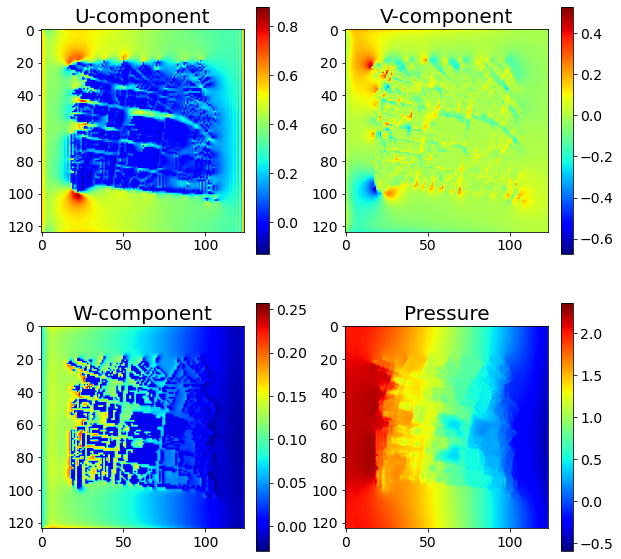

In [ ]:
serial_values_u = serial_values_u[0,0:-4,2:-2,2:-2,0].reshape(1,124,124,124,1)
serial_values_v = serial_values_v[0,0:-4,2:-2,2:-2,0].reshape(1,124,124,124,1)
serial_values_w = serial_values_w[0,0:-4,2:-2,2:-2,0].reshape(1,124,124,124,1)
serial_values_p = serial_values_p[0,0:-4,2:-2,2:-2,0].reshape(1,124,124,124,1)

# plot the serial result for 100 timesteps with 10 multi-grid interations for each
serial_result_list = [serial_values_u,serial_values_v,serial_values_w,serial_values_p]
plot_result(serial_result_list,1)

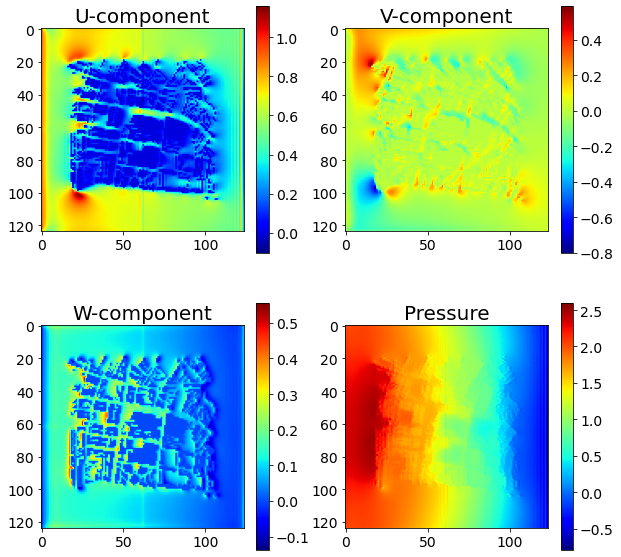

In [ ]:
# plot the parallel result
parallel_result_list = [parallel_values_u,parallel_values_v,parallel_values_w,parallel_values_p]
plot_result(parallel_result_list,1)

## looks sth was not updated on U direction ...
# fig, axs = plt.subplots(2, 2, figsize=(10, 10))
# plt.subplot(2,2,1)
# plt.imshow(parallel_result_list[0][0,1,:,:,0], cmap='jet')
# plt.colorbar()
# plt.title('U-component',Fontsize=20)
# plt.subplot(2,2,2)
# plt.imshow(parallel_result_list[1][0,1,:,:,0], cmap='jet')
# plt.colorbar()
# plt.title('V-component',Fontsize=20)
# plt.subplot(2,2,3)
# plt.imshow(parallel_result_list[2][0,1,:,:,0], cmap='jet')
# plt.colorbar()
# plt.title('W-component',Fontsize=20)
# plt.subplot(2,2,4)
# plt.imshow(parallel_result_list[3][0,1,:,:,0], cmap='jet')
# plt.colorbar()
# plt.title('Pressure',Fontsize=20)

### Accuracy Error

In [ ]:
from numpy import linalg as LA

print("ABEs: ")
print("u:",np.sum(np.abs(serial_values_u - parallel_values_u)))
print("v:",np.sum(np.abs(serial_values_v - parallel_values_v)))
print("w:",np.sum(np.abs(serial_values_w - parallel_values_w)))
print("p:",np.sum(np.abs(serial_values_p - parallel_values_p)))

print("AVG ABEs: ")
print("u:",np.sum(np.abs(serial_values_u - parallel_values_u))/(124*124*124))
print("v:",np.sum(np.abs(serial_values_v - parallel_values_v))/(124*124*124))
print("w:",np.sum(np.abs(serial_values_w - parallel_values_w))/(124*124*124))
print("p:",np.sum(np.abs(serial_values_p - parallel_values_p))/(124*124*124))

print("NORMS: ")
print("SERIAL: ")
print("u:",LA.norm(serial_values_u))
print("v:",LA.norm(serial_values_v))
print("w:",LA.norm(serial_values_w))
print("p:",LA.norm(serial_values_p))
print("PARALLEL: ")
print("u:",LA.norm(parallel_values_u))
print("v:",LA.norm(parallel_values_v))
print("w:",LA.norm(parallel_values_w))
print("p:",LA.norm(parallel_values_p))

print("AVG NORM ABE: ")
avg_norm_abe_u = np.abs(LA.norm(serial_values_u) - LA.norm(parallel_values_u)) / (124*124*124)
avg_norm_abe_v = np.abs(LA.norm(serial_values_v) - LA.norm(parallel_values_v)) / (124*124*124)
avg_norm_abe_w = np.abs(LA.norm(serial_values_w) - LA.norm(parallel_values_w)) / (124*124*124)
avg_norm_abe_p = np.abs(LA.norm(serial_values_p) - LA.norm(parallel_values_p)) / (124*124*124)

print("u:", avg_norm_abe_u)
print("v:", avg_norm_abe_v)
print("w:",avg_norm_abe_w)
print("p:",avg_norm_abe_p)

# ABEs: 
# u: 58945.46
# v: 21059.676
# w: 21394.158
# p: 479552.22
# AVG ABEs: 
# u: 0.03091614337042857
# v: 0.011045531673392341
# w: 0.011220963442778965
# p: 0.25151902984017827
# NORMS: 
# SERIAL: 
# u: 1034.2528
# v: 96.55818
# w: 91.18065
# p: 1572.4506
# PARALLEL: 
# u: 1039.4768
# v: 106.492195
# w: 102.96026
# p: 1895.4001
# AVG NORM ABE: 
# u: 2.7399209405931636e-06
# v: 5.210263463954727e-06
# w: 6.178255219789419e-06
# p: 0.0001693829433390839

ABEs: 
u: 63431.24
v: 21246.096
w: 21364.91
p: 510444.75
AVG ABEs: 
u: 0.033268876444044554
v: 0.011143306547659633
w: 0.011205623214776484
p: 0.2677217689486758
NORMS: 
SERIAL: 
u: 1025.4777
v: 95.47541
w: 90.485405
p: 1544.6606
PARALLEL: 
u: 1039.4768
v: 106.4922
w: 102.960266
p: 1895.4
AVG NORM ABE: 
u: 7.342373487280397e-06
v: 5.778167219841606e-06
w: 6.542905756467731e-06
p: 0.0001839583367684517


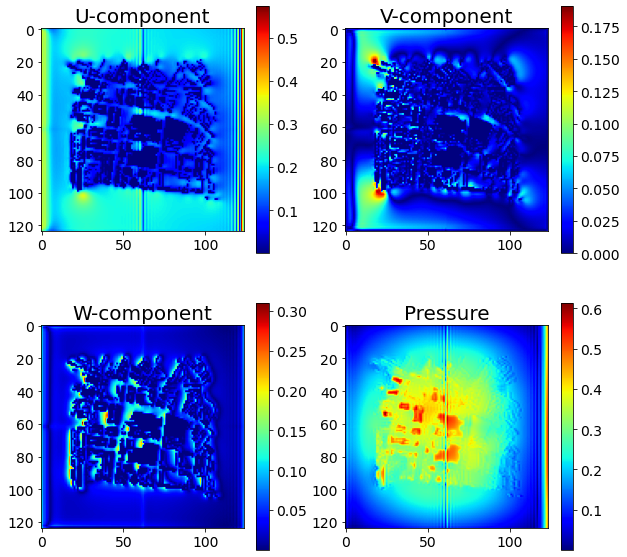

In [ ]:
abe_u = np.abs(serial_values_u - parallel_values_u)
abe_v = np.abs(serial_values_v - parallel_values_v)
abe_w = np.abs(serial_values_w - parallel_values_w)
abe_p = np.abs(serial_values_p - parallel_values_p)

# np.savetxt('serial_u.out', serial_values_u, delimiter=',') 
# np.savetxt('parallel_u.out', parallel_values_u, delimiter=',')
# np.savetxt('serial_v.out', serial_values_v, delimiter=',') 
# np.savetxt('parallel_v.out', parallel_values_v, delimiter=',') 
# np.savetxt('serial_w.out', serial_values_w, delimiter=',') 
# np.savetxt('parallel_w.out', parallel_values_w, delimiter=',') 
# np.savetxt('serial_p.out', serial_values_p, delimiter=',') 
# np.savetxt('parallel_p.out', parallel_values_p, delimiter=',') 

abe_list = [abe_u,abe_v,abe_w,abe_p]
# plot_result(abe_list,62)
plot_result(abe_list,1)

## Accuracy analysis

### Check Initial Condition

In [8]:
from numpy import linalg as LA

serial_IC = np.load('/content/initial_conditions/serial_IC.npy')
# reduced_serial_IC = serial_IC[0,2:-2,2:-2,2:-2,0]
reduced_serial_IC = serial_IC
plt.imshow(reduced_serial_IC[0,1,:,:,0], cmap='jet') # look from xy plane
plt.colorbar()
plt.title('central xy plane')
reduced_serial_IC.shape

In [ ]:
# parallel_IC = np.load('/content/initial_conditions/parallel_IC.npy')

parallel_IC_1 = np.load('/content/initial_conditions/parallel_IC_0.npy')
parallel_IC_2 = np.load('/content/initial_conditions/parallel_IC_1.npy')
parallel_IC_3 = np.load('/content/initial_conditions/parallel_IC_2.npy')
parallel_IC_4 = np.load('/content/initial_conditions/parallel_IC_3.npy')
parallel_IC_5 = np.load('/content/initial_conditions/parallel_IC_4.npy')
parallel_IC_6 = np.load('/content/initial_conditions/parallel_IC_5.npy')
parallel_IC_7 = np.load('/content/initial_conditions/parallel_IC_6.npy')
parallel_IC_8 = np.load('/content/initial_conditions/parallel_IC_7.npy')


temp1 = np.concatenate([parallel_IC_1,parallel_IC_2], axis = 3)
temp2 = np.concatenate([parallel_IC_3,parallel_IC_4], axis = 3)
level_1 = np.concatenate([temp1, temp2], axis = 2)

temp3 = np.concatenate([parallel_IC_5,parallel_IC_6], axis = 3)
temp4 = np.concatenate([parallel_IC_7,parallel_IC_8], axis = 3)
level_2 = np.concatenate([temp3, temp4], axis = 2)

parallel_IC = np.concatenate([level_1,level_2], axis=1).reshape(1,128,128,128,1)

plt.imshow(parallel_IC[0,1,:,:,0], cmap='jet') # look from xy plane
plt.colorbar()
plt.title('central xy plane')
parallel_IC.shape

In [ ]:
reduced_serial_IC = reduced_serial_IC.reshape(1,124,124,124,1)

norm_serial = LA.norm(reduced_serial_IC)
norm_parallel = LA.norm(parallel_IC)

print(LA.norm(reduced_serial_IC))
print(LA.norm(parallel_IC))
abe = np.abs(norm_serial - norm_parallel)
print(abe)

abe_grids = np.abs(reduced_serial_IC - parallel_IC)

plt.imshow(abe_grids[0,1,:,:,0], cmap='jet') # look from xy plane
plt.colorbar()
plt.title('central xy plane')
np.allclose(reduced_serial_IC,parallel_IC)

### Check the initial boundary conditions

In [ ]:
serial_bc_u = np.load('/content/boundary_conditions/serial_values_u.npy')
serial_bc_v = np.load('/content/boundary_conditions/serial_values_v.npy')
serial_bc_w = np.load('/content/boundary_conditions/serial_values_w.npy')
serial_bc_p = np.load('/content/boundary_conditions/serial_values_p.npy')

# serial_bc_u = serial_bc_u[0,2:-2,2:-2,2:-2,0].reshape(1,124,124,124,1)
# serial_bc_v = serial_bc_v[0,2:-2,2:-2,2:-2,0].reshape(1,124,124,124,1)
# serial_bc_w = serial_bc_w[0,2:-2,2:-2,2:-2,0].reshape(1,124,124,124,1)
# serial_bc_p = serial_bc_p[0,2:-2,2:-2,2:-2,0].reshape(1,124,124,124,1)

serial_bc_list = [serial_bc_u,serial_bc_v,serial_bc_w,serial_bc_p]
plot_result(serial_bc_list,1)

print(np.max(serial_bc_u),np.min(serial_bc_u))
print(np.max(serial_bc_v),np.min(serial_bc_v))
print(np.max(serial_bc_w),np.min(serial_bc_w))
print(np.max(serial_bc_p),np.min(serial_bc_p))
print(serial_bc_u.shape)
# assert np.allclose(serial_bc_u,0)
# assert np.allclose(serial_bc_v,0)
# assert np.allclose(serial_bc_w,0)
# assert np.allclose(serial_bc_p,0)

In [ ]:
def load_parallel_bc(item_name,proc_nums):
    parallel_results = []
    for i in range(proc_nums):
        temp_subdomain = np.load("/content/boundary_conditions/parallel_values_{}_{}.npy".format(item_name,i))
        temp_subdomain = temp_subdomain[0,1:-1,1:-1,1:-1,0].reshape(62,62,62)
        # temp_subdomain = temp_subdomain.reshape(64,64,64)
        parallel_results.append(temp_subdomain)
    
    return parallel_results

parallel_u_bcs = load_parallel_bc('u',8)
parallel_v_bcs = load_parallel_bc('v',8)
parallel_w_bcs = load_parallel_bc('w',8)
parallel_p_bcs = load_parallel_bc('p',8)

parallel_u_bc = merge_parallel_results_8(parallel_u_bcs).reshape(1,124,124,124,1)
parallel_v_bc = merge_parallel_results_8(parallel_v_bcs).reshape(1,124,124,124,1)
parallel_w_bc = merge_parallel_results_8(parallel_w_bcs).reshape(1,124,124,124,1)
parallel_p_bc = merge_parallel_results_8(parallel_p_bcs).reshape(1,124,124,124,1)

# parallel_u_bc = merge_parallel_results_8(parallel_u_bcs).reshape(1,128,128,128,1)
# parallel_v_bc = merge_parallel_results_8(parallel_v_bcs).reshape(1,128,128,128,1)
# parallel_w_bc = merge_parallel_results_8(parallel_w_bcs).reshape(1,128,128,128,1)
# parallel_p_bc = merge_parallel_results_8(parallel_p_bcs).reshape(1,128,128,128,1)

parallel_bc_list = [parallel_u_bc,parallel_v_bc,parallel_w_bc,parallel_p_bc]
plot_result(parallel_bc_list,1)

print(np.max(parallel_u_bc),np.min(parallel_u_bc))
print(np.max(parallel_v_bc),np.min(parallel_v_bc))
print(np.max(parallel_w_bc),np.min(parallel_w_bc))
print(np.max(parallel_p_bc),np.min(parallel_p_bc))
print(parallel_u_bc.shape)


In [ ]:
from numpy import linalg as LA
print("NORMS: ")
print("SERIAL: ")
print("u:",LA.norm(serial_bc_u))
print("v:",LA.norm(serial_bc_v))
print("w:",LA.norm(serial_bc_w))
print("p:",LA.norm(serial_bc_p))
print("PARALLEL: ")
print("u:",LA.norm(parallel_u_bc))
print("v:",LA.norm(parallel_v_bc))
print("w:",LA.norm(parallel_w_bc))
print("p:",LA.norm(parallel_p_bc))

print("\n")
print("AVG NORM ABE: ")
avg_norm_abe_u = np.abs(LA.norm(serial_bc_u) - LA.norm(parallel_u_bc)) / (124*124*124)
avg_norm_abe_v = np.abs(LA.norm(serial_bc_v) - LA.norm(parallel_v_bc)) / (124*124*124)
avg_norm_abe_w = np.abs(LA.norm(serial_bc_w) - LA.norm(parallel_w_bc)) / (124*124*124)
avg_norm_abe_p = np.abs(LA.norm(serial_bc_p) - LA.norm(parallel_p_bc)) / (124*124*124)

print("u:", avg_norm_abe_u)
print("v:", avg_norm_abe_v)
print("w:",avg_norm_abe_w)
print("p:",avg_norm_abe_p)

In [ ]:
# Write the array to disk
# data = serial_bc_u.reshape(124,124,124)
# data = parallel_u_bc.reshape(124,124,124)
# data = serial_IC.reshape(128,128,128)
data = parallel_IC.reshape(128,128,128)
with open('u2.txt', 'w') as outfile:
    # I'm writing a header here just for the sake of readability
    # Any line starting with "#" will be ignored by numpy.loadtxt
    outfile.write('# Array shape: {0}\n'.format(data.shape))
    
    # Iterating through a ndimensional array produces slices along
    # the last axis. This is equivalent to data[i,:,:] in this case
    for data_slice in data:

        # The formatting string indicates that I'm writing out
        # the values in left-justified columns 7 characters in width
        # with 2 decimal places.  
        np.savetxt(outfile, data_slice, fmt='%-7.2f')

        # Writing out a break to indicate different slices...
        outfile.write('# New slice\n')

### Check the results on 1 MPI process

In [ ]:
serial_values_u = np.load('/content/serial_output/serial_values_u.npy')
serial_values_v = np.load('/content/serial_output/serial_values_v.npy')
serial_values_w = np.load('/content/serial_output/serial_values_w.npy')
serial_values_p = np.load('/content/serial_output/serial_values_p.npy')

# parallel_values_u = np.load('/content/parallel_output/parallel_values_u.npy')
# parallel_values_v = np.load('/content/parallel_output/parallel_values_v.npy')
# parallel_values_w = np.load('/content/parallel_output/parallel_values_w.npy')
# parallel_values_p = np.load('/content/parallel_output/parallel_values_p.npy')

# assert np.allclose(serial_values_u,parallel_values_u)
# assert np.allclose(serial_values_v,parallel_values_v)
# assert np.allclose(serial_values_w,parallel_values_w)
# assert np.allclose(serial_values_p,parallel_values_p)

In [ ]:
serial_result_list = [serial_values_u,serial_values_v,serial_values_w,serial_values_p]
plot_result(serial_result_list,1)

In [ ]:
parallel_result_list = [parallel_values_u,parallel_values_v,parallel_values_w,parallel_values_p]
plot_result(parallel_result_list,1)